In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
import os

# Print the current working directory
print("Current Directory:", os.getcwd())


# Change directory (e.g., move to a subdirectory or navigate to another path)
os.chdir('/content/drive/MyDrive/RFSR')

# Print the new working directory
print("New Directory:", os.getcwd())

Current Directory: /content
New Directory: /content/drive/MyDrive/RFSR


In [5]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
  Attempting unins

In [6]:
!tar -xf '/content/drive/MyDrive/Assignment_ML/SuperResolution.tar.xz' -C '/content/'

In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def debug(message, variable=None):
    """Print debug information."""
    print(f"[DEBUG] {message}")
    if variable is not None:
        print(f"        Value: {variable}")

# Crop center utility
def crop_center(array, cropx, cropy):
    y, x = array.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return array[starty:starty + cropy, startx:startx + cropx]

# Convert image to YCbCr
def Calc_YCbCr(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return None
    Blue, Green, Red = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    Y = 0.299 * Red + 0.587 * Green + 0.114 * Blue
    Cb = 128 - 0.168736 * Red - 0.331264 * Green + 0.5 * Blue
    Cr = 128 + 0.5 * Red - 0.418688 * Green - 0.081312 * Blue
    return np.stack((Y, Cb, Cr), axis=-1)

# Upscale low-resolution array
def Upscale_Array(LR_Array, HR_Shape):
    RasHolder = []
    for i in range(LR_Array.shape[-1]):
        HR_Resample = cv2.resize(LR_Array[:, :, i], (HR_Shape[1], HR_Shape[0]), interpolation=cv2.INTER_CUBIC)
        RasHolder.append(HR_Resample)
    return np.stack(RasHolder, axis=-1)


# Downscale high-resolution array
def Downscale_Array(HR_Array, factor=2):
    RasHolder = []
    for i in range(HR_Array.shape[-1]):
        HR_Resample = cv2.resize(HR_Array[:, :, i],
                                 (HR_Array.shape[1] // factor, HR_Array.shape[0] // factor),
                                 interpolation=cv2.INTER_CUBIC)
        RasHolder.append(HR_Resample)
    return np.stack(RasHolder, axis=-1)

# Create multi-band GeoTIFF
def CreateMultiBandGeoTiff(Array, Name):
    cv2.imwrite(Name, Array)
    print(f"Saved: {Name}")


# Shift array to create 3D cube
def Shift_Array(input_array, shift_dimension=2):
    shift_holder = []
    for dy in range(-shift_dimension, shift_dimension + 1):
        for dx in range(-shift_dimension, shift_dimension + 1):
            shifted = np.roll(input_array, shift=dy, axis=0)
            shifted = np.roll(shifted, shift=dx, axis=1)
            shift_holder.append(shifted)
    return np.asarray(shift_holder).astype(int)

# Process images from directories
def process_images_from_directory(HR_image_directory, LR_image_directory):
    HR_files = sorted([f for f in os.listdir(HR_image_directory) if f.endswith(('png', 'jpg', 'jpeg'))])
    LR_files = sorted([f for f in os.listdir(LR_image_directory) if f.endswith(('png', 'jpg', 'jpeg'))])

    # Create a mapping between HR filenames and corresponding LR filenames based on the naming convention
    HR_LR_pairs = []
    for HR_file in HR_files:
        HR_base = os.path.splitext(HR_file)[0]  # e.g., "0801"
        LR_file = f"{HR_base}x4m.png"  # Add "x4m" suffix for LR filename
        if LR_file in LR_files:
            HR_LR_pairs.append((HR_file, LR_file))
        else:
            print(f"Warning: No corresponding LR file found for HR file {HR_file}")

    for HR_file, LR_file in HR_LR_pairs:
        HR_path = os.path.join(HR_image_directory, HR_file)
        LR_path = os.path.join(LR_image_directory, LR_file)

        print(f"\nProcessing HR: {HR_path}, LR: {LR_path}")

        HR_YCbCr = Calc_YCbCr(HR_path)
        LR_YCbCr = Calc_YCbCr(LR_path)

        if HR_YCbCr is None or LR_YCbCr is None:
            print(f"Skipping due to error in YCbCr conversion for {HR_path} or {LR_path}.")
            continue

        # Debugging dimensions
        debug("HR dimensions", HR_YCbCr.shape)
        debug("LR dimensions", LR_YCbCr.shape)

        HR_shape = HR_YCbCr.shape[:2]
        LR_upscaled = Upscale_Array(LR_YCbCr, HR_shape)

        # Check if LR upscaled matches HR dimensions
        debug("LR Upscaled dimensions", LR_upscaled.shape)
        if LR_upscaled.shape[:2] != HR_shape:
            print(f"Error: Upscaled LR dimensions do not match HR dimensions for {HR_file}.")
            continue

        Downscaled_HR = Downscale_Array(HR_YCbCr, factor=4)

        # Debugging function results
        debug("Downscaled HR dimensions", Downscaled_HR.shape)

        CreateMultiBandGeoTiff(LR_upscaled, f"{HR_file}_LR_upscaled.png")
        CreateMultiBandGeoTiff(Downscaled_HR, f"{HR_file}_Downscaled_HR.png")

if __name__ == "__main__":
    HR_image_directory = '/content/SuperResolution/HR'  # Update with actual directory path
    LR_image_directory = '/content/SuperResolution/LR'  # Update with actual directory path

    process_images_from_directory(HR_image_directory, LR_image_directory)



Processing HR: /content/SuperResolution/HR/0801.png, LR: /content/SuperResolution/LR/0801x4m.png
[DEBUG] HR dimensions
        Value: (1356, 2040, 3)
[DEBUG] LR dimensions
        Value: (339, 510, 3)
[DEBUG] LR Upscaled dimensions
        Value: (1356, 2040, 3)
[DEBUG] Downscaled HR dimensions
        Value: (339, 510, 3)
Saved: 0801.png_LR_upscaled.png
Saved: 0801.png_Downscaled_HR.png

Processing HR: /content/SuperResolution/HR/0802.png, LR: /content/SuperResolution/LR/0802x4m.png
[DEBUG] HR dimensions
        Value: (1356, 2040, 3)
[DEBUG] LR dimensions
        Value: (339, 510, 3)
[DEBUG] LR Upscaled dimensions
        Value: (1356, 2040, 3)
[DEBUG] Downscaled HR dimensions
        Value: (339, 510, 3)
Saved: 0802.png_LR_upscaled.png
Saved: 0802.png_Downscaled_HR.png

Processing HR: /content/SuperResolution/HR/0803.png, LR: /content/SuperResolution/LR/0803x4m.png
[DEBUG] HR dimensions
        Value: (1536, 2040, 3)
[DEBUG] LR dimensions
        Value: (384, 510, 3)
[DEBUG] LR Ups

[[0.68413733 0.69132134 0.69290701 ... 0.         0.         0.        ]
 [0.67432529 0.68413733 0.69132134 ... 0.         0.         0.        ]
 [0.66336052 0.67432529 0.68413733 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.1293078  0.14007978 0.15204042]
 [0.         0.         0.         ... 0.12154934 0.1293078  0.14007978]
 [0.         0.         0.         ... 0.1198464  0.12154934 0.1293078 ]]
[ 0.13054931  0.11597752  0.10145129 ... -0.00162105  0.04237908
  0.05605092]
Train shape: (2766240, 25), Target shape: (2766240,)


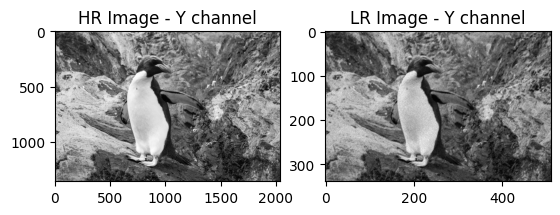

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2  # Assuming OpenCV is used for image processing

def Calc_YCbCr(image_path):
    """
    Convert an image to YCbCr format.
    Args:
        image_path (str): Path to the image.
    Returns:
        numpy.ndarray: Image in YCbCr format.
    """
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    ycbcr_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2YCrCb)
    return ycbcr_image

def Upscale_Array(LR_Array, HR_shape):
    """
    Upscale a low-resolution array to match the shape of a high-resolution image.
    Args:
        LR_Array (numpy.ndarray): Low-resolution image.
        HR_shape (tuple): Shape of the high-resolution image.
    Returns:
        numpy.ndarray: Upscaled low-resolution image.
    """
    upscaled = cv2.resize(LR_Array, (HR_shape[1], HR_shape[0]), interpolation=cv2.INTER_CUBIC)
    return upscaled

def Shift_Array(padded_array, shift_dimension=2):
    """
    Generate shifted patches from a padded array.
    Args:
        padded_array (numpy.ndarray): Padded array for generating shifts.
        shift_dimension (int): Dimension of the shift window.
    Returns:
        numpy.ndarray: Shifted patches.
    """
    shifts = []
    for x_shift in range(-shift_dimension, shift_dimension + 1):
        for y_shift in range(-shift_dimension, shift_dimension + 1):
            shifted = np.roll(padded_array, shift=(x_shift, y_shift), axis=(0, 1))
            shifts.append(shifted)
    return np.array(shifts)

def Normalize_Array(array, range_min=0, range_max=255):
    """
    Normalize an array to a specified range (default: 0 to 1).
    Args:
        array (numpy.ndarray): Input array.
        range_min (float): Minimum value for normalization.
        range_max (float): Maximum value for normalization.
    Returns:
        numpy.ndarray: Normalized array.
    """
    return (array - range_min) / (range_max - range_min)

def DeNormalize_Array(array, range_min=0, range_max=255):
    """
    De-normalize an array back to its original range.
    Args:
        array (numpy.ndarray): Normalized array.
        range_min (float): Minimum value for de-normalization.
        range_max (float): Maximum value for de-normalization.
    Returns:
        numpy.ndarray: De-normalized array.
    """
    return array * (range_max - range_min) + range_min

def Create_SR_TrainingData(LR_Array, HR_Array, shift_dimension=2, index=0):
    """
    Create training data for super-resolution by generating patches and residuals.
    Args:
        LR_Array (numpy.ndarray): Low-resolution image array.
        HR_Array (numpy.ndarray): High-resolution image array.
        shift_dimension (int): Dimension of the shifting window.
        index (int): Index of the channel to process (e.g., Y channel).
    Returns:
        tuple: Training features (Train) and target residuals (Target).
    """
    # Normalize LR and HR arrays
    LR_Array_normalized = Normalize_Array(LR_Array)
    HR_Array_normalized = Normalize_Array(HR_Array)

    # Upscale the normalized LR image to HR shape
    Bicube_LR = Upscale_Array(LR_Array_normalized, HR_Array_normalized.shape[:2])
    Bicube_LR_channel = Bicube_LR[:, :, index]
    HR_Array_channel = HR_Array_normalized[:, :, index]

    # Calculate residuals
    HR_Residuals = HR_Array_channel - Bicube_LR_channel

    # Pad and generate shifted patches
    Bicube_LR_padded = np.pad(Bicube_LR_channel, pad_width=shift_dimension, mode='constant', constant_values=0)
    BC_LR_Shift = Shift_Array(Bicube_LR_padded, shift_dimension=shift_dimension)

    # Calculate valid dimensions after padding
    valid_height, valid_width = HR_Array_channel.shape
    nfeatures = BC_LR_Shift.shape[0]

    # Extract valid regions and reshape
    BC_LR_Shift = BC_LR_Shift[:, shift_dimension:shift_dimension + valid_height, shift_dimension:shift_dimension + valid_width]
    Train = BC_LR_Shift.reshape(nfeatures, valid_height * valid_width).T
    Target = HR_Residuals.flatten()

    # Check consistency
    assert Train.shape[0] == Target.shape[0], "Inconsistent shapes between Train and Target."
    print(Train)
    print(Target)
    return Train, Target

# Example usage
if __name__ == "__main__":
    HR_image_directory = '/content/SuperResolution/HR'
    LR_image_directory = '/content/SuperResolution/LR'

    HR_files = sorted([f for f in os.listdir(HR_image_directory) if f.endswith(('png', 'jpg', 'jpeg'))])
    LR_files = sorted([f for f in os.listdir(LR_image_directory) if f.endswith(('png', 'jpg', 'jpeg'))])

    if not HR_files or not LR_files:
        raise ValueError("HR or LR image directories are empty.")

    HR_file = HR_files[0]
    LR_file = LR_files[0]

    HR_path = os.path.join(HR_image_directory, HR_file)
    LR_path = os.path.join(LR_image_directory, LR_file)

    HR_YCbCr = Calc_YCbCr(HR_path)
    LR_YCbCr = Calc_YCbCr(LR_path)

    Train, Target = Create_SR_TrainingData(LR_YCbCr, HR_YCbCr)
    print(f"Train shape: {Train.shape}, Target shape: {Target.shape}")

    plt.subplot(1, 2, 1)
    plt.imshow(HR_YCbCr[:, :, 0], cmap='gray')
    plt.title("HR Image - Y channel")

    plt.subplot(1, 2, 2)
    plt.imshow(LR_YCbCr[:, :, 0], cmap='gray')
    plt.title("LR Image - Y channel")
    plt.show()


In [24]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def debug(message, variable=None):
    """Print debug information."""
    print(f"[DEBUG] {message}")
    if variable is not None:
        print(f"        Value: {variable}")

# Resize YCbCr array to a target shape
def Resize_YCbCr(array, target_shape=(1356, 2040)):
    """
    Resize the Y, Cb, and Cr channels of a YCbCr array to the target shape.

    Parameters:
        array (np.ndarray): The input YCbCr array of shape (H, W, 3).
        target_shape (tuple): The desired (height, width) for the output.

    Returns:
        np.ndarray: Resized YCbCr array with shape (target_height, target_width, 3).
    """
    target_height, target_width = target_shape

    resized_channels = []
    for i in range(3):  # Iterate over Y, Cb, Cr channels
        resized_channel = cv2.resize(array[:, :, i], (target_width, target_height), interpolation=cv2.INTER_CUBIC)
        resized_channels.append(resized_channel)

    return np.stack(resized_channels, axis=-1)

# Visualize images
def visualize_images(HR_resized, bicubic_LR, HR_original=None):
    """
    Visualize HR image, resized HR image, and bicubic LR image.

    Parameters:
        HR_resized (np.ndarray): Resized HR Y channel.
        bicubic_LR (np.ndarray): Bicubic LR Y channel.
        HR_original (np.ndarray): Optional original HR image.
    """
    plt.figure(figsize=(15, 5))

    if HR_original is not None:
        plt.subplot(1, 3, 1)
        plt.imshow(HR_original[:, :, 0], cmap='gray')
        plt.title("Original HR Y Channel")
        plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(HR_resized, cmap='gray')
    plt.title("Resized HR Y Channel")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(bicubic_LR, cmap='gray')
    plt.title("Bicubic LR Y Channel")
    plt.axis('off')

    plt.show()

def process_images_from_directory(HR_image_directory, LR_image_directory):
    HR_files = sorted([f for f in os.listdir(HR_image_directory) if f.endswith(('png', 'jpg', 'jpeg'))])
    LR_files = sorted([f for f in os.listdir(LR_image_directory) if f.endswith(('png', 'jpg', 'jpeg'))])

    HR_LR_pairs = []
    for HR_file in HR_files:
        HR_base = os.path.splitext(HR_file)[0]
        LR_file = f"{HR_base}x4m.png"
        if LR_file in LR_files:
            HR_LR_pairs.append((HR_file, LR_file))
        else:
            print(f"Warning: No corresponding LR file found for HR file {HR_file}")

    for HR_file, LR_file in HR_LR_pairs:
        HR_path = os.path.join(HR_image_directory, HR_file)
        LR_path = os.path.join(LR_image_directory, LR_file)

        print(f"\nProcessing HR: {HR_path}, LR: {LR_path}")

        HR_YCbCr = Calc_YCbCr(HR_path)
        LR_YCbCr = Calc_YCbCr(LR_path)

        if HR_YCbCr is None or LR_YCbCr is None:
            print(f"Skipping due to error in YCbCr conversion for {HR_path} or {LR_path}.")
            continue

        # Resize HR_YCbCr to (1356, 2040, 3) for MSE computation
        HR_YCbCr_resized = Resize_YCbCr(HR_YCbCr, target_shape=(1356, 2040))

        # Debugging dimensions
        # debug("Original HR_YCbCr dimensions", HR_YCbCr.shape)
        debug("Resized HR_YCbCr dimensions", HR_YCbCr_resized.shape)

        # Normalize pixel values to [0, 1]
        HR_YCbCr_resized = HR_YCbCr_resized / 255.0
        LR_YCbCr = LR_YCbCr / 255.0

        # Ensure dimensions of HR_YCbCr_resized match the bicubic_LR_channel for MSE computation
        bicubic_LR_channel = cv2.resize(LR_YCbCr[:, :, 0], (2040, 1356), interpolation=cv2.INTER_CUBIC)

        # Check dimensions of both arrays for debugging
        debug("HR Y Channel Shape", HR_YCbCr_resized[:, :, 0].shape)
        debug("Bicubic LR Y Channel Shape", bicubic_LR_channel.shape)

        # Ensure orientation is consistent
        if HR_YCbCr_resized[:, :, 0].shape != bicubic_LR_channel.shape:
            print(f"Error: Shapes do not match for subtraction. HR shape: {HR_YCbCr_resized[:, :, 0].shape}, Bicubic LR shape: {bicubic_LR_channel.shape}")
            continue

        # Compute residuals and MSE
        residuals = HR_YCbCr_resized[:, :, 0] - bicubic_LR_channel
        MSE = np.mean(residuals**2)
        debug("MSE between HR and Bicubic LR", MSE)

        # Visualize the images
        visualize_images(HR_YCbCr_resized[:, :, 0], bicubic_LR_channel, HR_original=HR_YCbCr)

if __name__ == "__main__":
    HR_image_directory = '/content/SuperResolution/HR'  # Update with actual directory path
    LR_image_directory = '/content/SuperResolution/LR'  # Update with actual directory path

    process_images_from_directory(HR_image_directory, LR_image_directory)


Output hidden; open in https://colab.research.google.com to view.

[[0.68413733 0.69132134 0.69290701 ... 0.         0.         0.        ]
 [0.67432529 0.68413733 0.69132134 ... 0.         0.         0.        ]
 [0.66336052 0.67432529 0.68413733 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.1293078  0.14007978 0.15204042]
 [0.         0.         0.         ... 0.12154934 0.1293078  0.14007978]
 [0.         0.         0.         ... 0.1198464  0.12154934 0.1293078 ]]
[ 0.13054931  0.11597752  0.10145129 ... -0.00162105  0.04237908
  0.05605092]
[DEBUG] Train shape: (2766240, 25), Target shape: (2766240,)


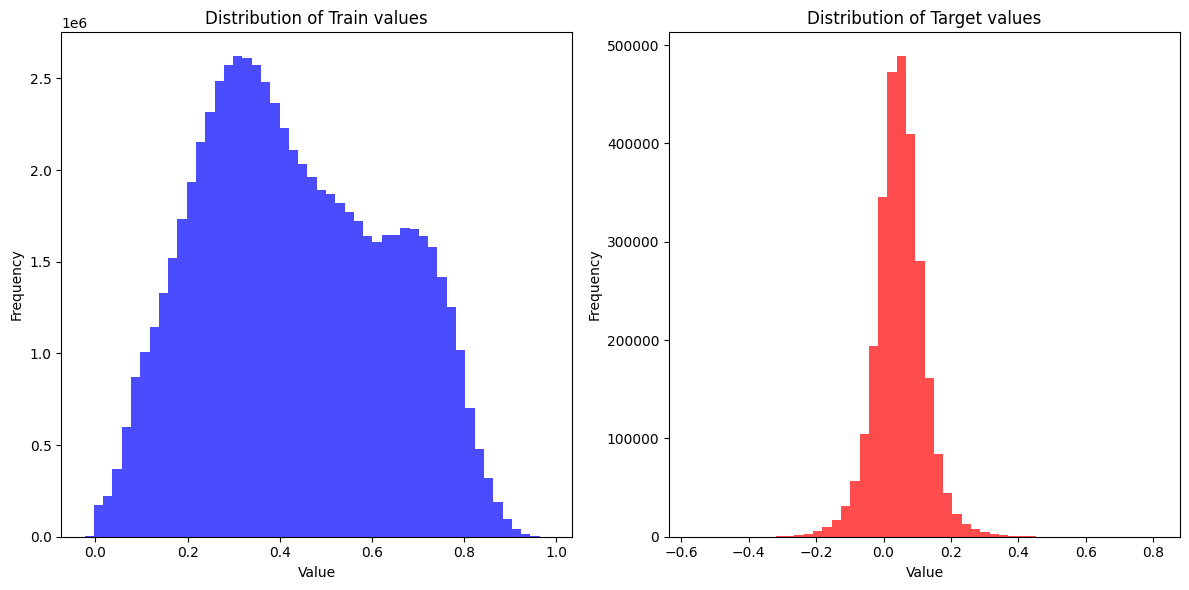

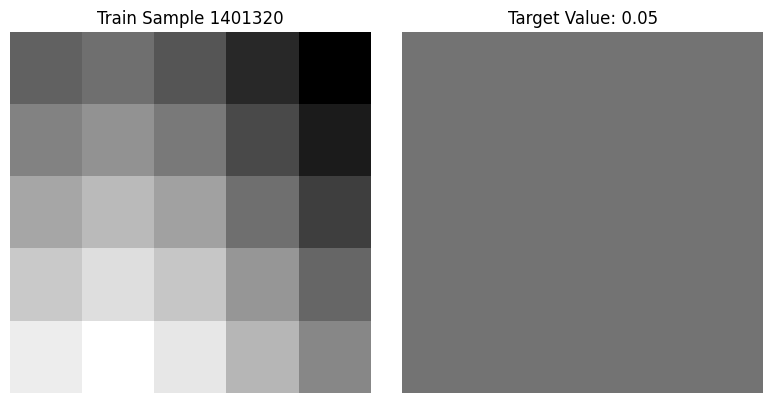

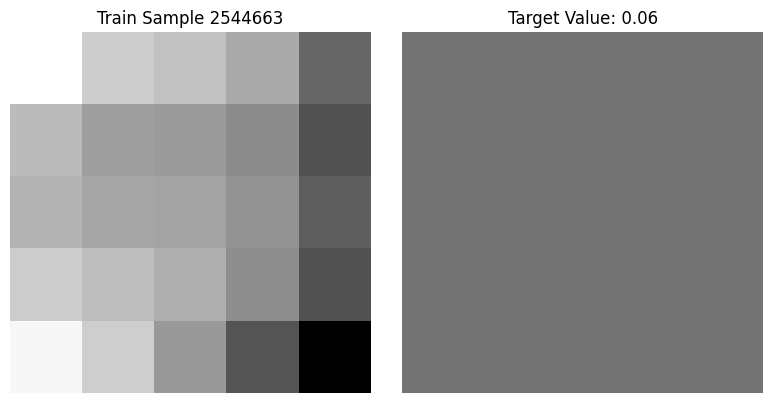

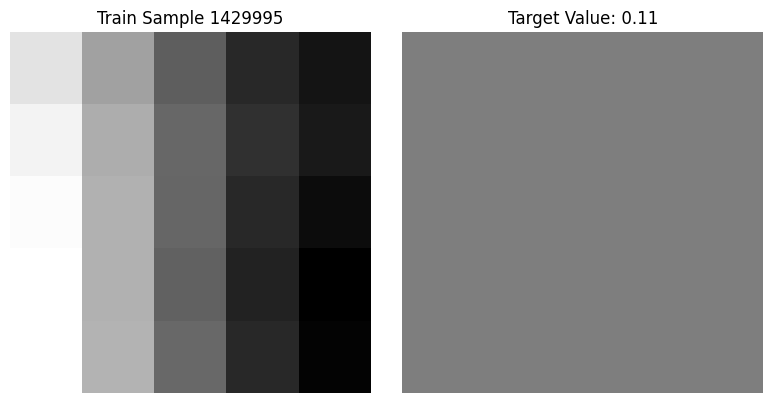

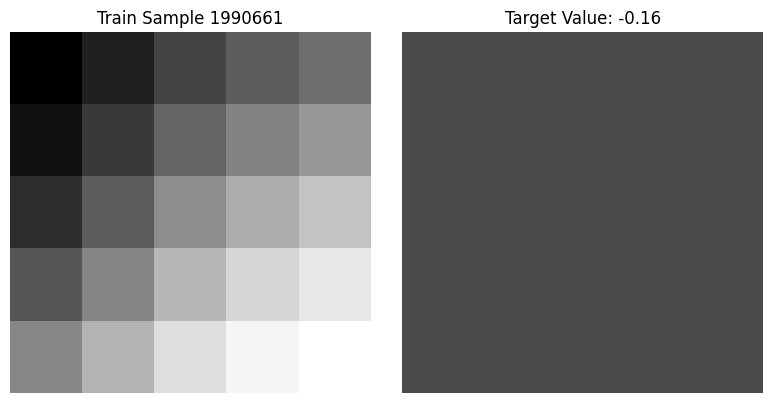

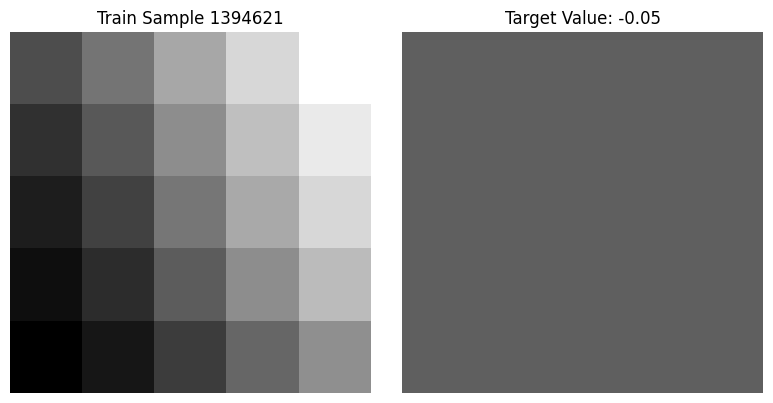

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt


def visualize_distribution(Train, Target):
    """
    Visualizes the distribution of the Train and Target arrays.
    """
    # Flatten the arrays for histogram plotting
    train_flat = Train.flatten()
    target_flat = Target.flatten()

    # Plot histograms of Train and Target
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(train_flat, bins=50, color='b', alpha=0.7)
    plt.title('Distribution of Train values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(target_flat, bins=50, color='r', alpha=0.7)
    plt.title('Distribution of Target values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


def visualize_samples(Train, Target, shift_dimension=2, num_samples=5):
    """
    Visualizes a few samples from Train and Target.
    """
    # Randomly select a few samples
    sample_indices = np.random.choice(Train.shape[0], num_samples, replace=False)

    for i in sample_indices:
        # Reshape and show images from the Train array
        train_sample = Train[i, :].reshape(shift_dimension * 2 + 1, shift_dimension * 2 + 1)
        target_sample = Target[i]

        # Plot the Train and Target images
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        ax1.imshow(train_sample, cmap='gray')
        ax1.set_title(f'Train Sample {i}')
        ax1.axis('off')

        # Visualizing the target as a single pixel value
        ax2.imshow(np.array([[target_sample]]), cmap='gray', vmin=np.min(Target), vmax=np.max(Target))
        ax2.set_title(f'Target Value: {target_sample:.2f}')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    # Assuming Train and Target arrays have been created
    HR_image_directory = '/content/SuperResolution/HR'
    LR_image_directory = '/content/SuperResolution/LR'

    # Get the first HR and LR image pair
    HR_files = sorted([f for f in os.listdir(HR_image_directory) if f.endswith(('png', 'jpg', 'jpeg'))])
    LR_files = sorted([f for f in os.listdir(LR_image_directory) if f.endswith(('png', 'jpg', 'jpeg'))])

    if not HR_files or not LR_files:
        raise ValueError("HR or LR image directories are empty.")

    HR_file = HR_files[0]
    LR_file = LR_files[0]

    # Form paths to the images
    HR_path = os.path.join(HR_image_directory, HR_file)
    LR_path = os.path.join(LR_image_directory, LR_file)

    # Calc YCbCr for both images (Assuming Calc_YCbCr is defined elsewhere)
    HR_YCbCr = Calc_YCbCr(HR_path)
    LR_YCbCr = Calc_YCbCr(LR_path)

    # Now call Create_SR_TrainingData
    Train, Target = Create_SR_TrainingData(LR_YCbCr, HR_YCbCr)

    # Print the shapes of Train and Target
    print(f"[DEBUG] Train shape: {Train.shape}, Target shape: {Target.shape}")

    # Visualize the distributions of Train and Target
    visualize_distribution(Train, Target)

    # Visualize some random samples of Train and Target
    visualize_samples(Train, Target, shift_dimension=2, num_samples=5)


In [68]:
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Start Random Forest Regression
train_size = int(0.8 * Train.shape[0])
test_size = Train.shape[0] - train_size

Train_TrainSet, Train_TestSet = Train[:train_size], Train[train_size:]
Target_TrainSet, Target_TestSet = Target[:train_size], Target[train_size:]

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    min_samples_split=200,
    n_jobs=-1,
    verbose=1,
    oob_score=True
)

t1 = datetime.datetime.now()
print(f"Training started at: {t1}")

rf.fit(Train_TrainSet, Target_TrainSet)

t2 = datetime.datetime.now()
print(f"Training ended at: {t2}")
print(f"Time taken: {t2 - t1}")

mse = mean_squared_error(Target_TestSet, rf.predict(Train_TestSet))
psnr = 20 * np.log10(255 / np.sqrt(mse))

print(f"MSE: {mse}")
print(f"PSNR: {psnr}")

Training started at: 2024-11-24 17:22:52.696603


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 58.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 125.9min finished


Training ended at: 2024-11-24 19:29:12.718809
Time taken: 2:06:20.022206


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.1s


MSE: 0.005184694920650161
PSNR: 70.983571542752


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.6s finished


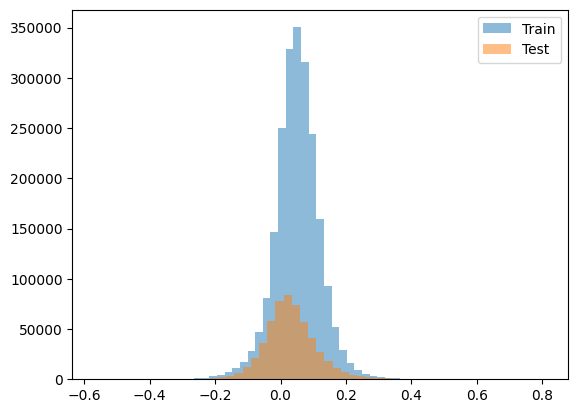

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   28.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Train MSE: 0.0029503849611846504
Train PSNR: 73.43201675191219


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.5s


Train Predictions (first 5): [0.12662027 0.12740028 0.05802468 0.05509109 0.04204186]
Train Targets (first 5): [0.13054931 0.11597752 0.10145129 0.08499389 0.0693097 ]


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   22.5s finished


In [69]:
# Check the distribution of target variables in Train and Test sets
import matplotlib.pyplot as plt

plt.hist(Target_TrainSet[:train_size], bins=50, alpha=0.5, label='Train')
plt.hist(Target_TestSet[:test_size], bins=50, alpha=0.5, label='Test')
plt.legend()
plt.show()

# Check the performance on both train and test data
train_mse = mean_squared_error(Target_TrainSet[:train_size], rf.predict(Train_TrainSet[:train_size]))
train_psnr = 20 * np.log10(255 / np.sqrt(train_mse))

print(f"Train MSE: {train_mse}")
print(f"Train PSNR: {train_psnr}")

# If you still get perfect performance, check the model's predictions
train_predictions = rf.predict(Train_TrainSet[:train_size])
print("Train Predictions (first 5):", train_predictions[:5])
print("Train Targets (first 5):", Target_TrainSet[:train_size][:5])


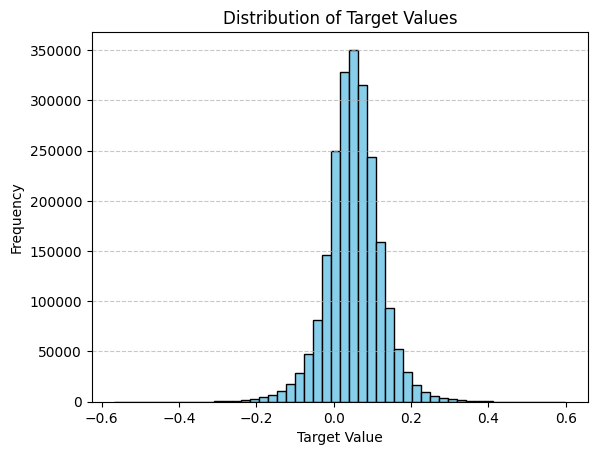

In [21]:
# Check the distribution of target values
plt.hist(Target_TrainSet[:train_size], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Target Values")
plt.xlabel("Target Value")  # X-axis label
plt.ylabel("Frequency")     # Y-axis label
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid for better readability
plt.show()


In [73]:
import os
import joblib

# Define your directory and filename
directory = "/content/drive/MyDrive/Assignment_ML"  # Replace with your desired location
os.makedirs(directory, exist_ok=True)  # Create directory if it doesn't exist
model_filename = os.path.join(directory, "rf_sr_model.pkl")

# Save the trained model
joblib.dump(rf, model_filename)
print(f"Model saved to {model_filename}")


Model saved to /content/drive/MyDrive/Assignment_ML/rf_sr_model.pkl


Model loaded from /content/drive/MyDrive/Assignment_ML/rf_sr_model.pkl
[DEBUG] Original HR_YCbCr dimensions
        Value: (1356, 2040, 3)
[DEBUG] Resized HR_YCbCr dimensions
        Value: (1356, 2040, 3)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.9s finished


Predicted residuals length: 553248
bicubic_LR_channel shape: (1356, 2040)
Target shape for residuals: (1356, 2040)


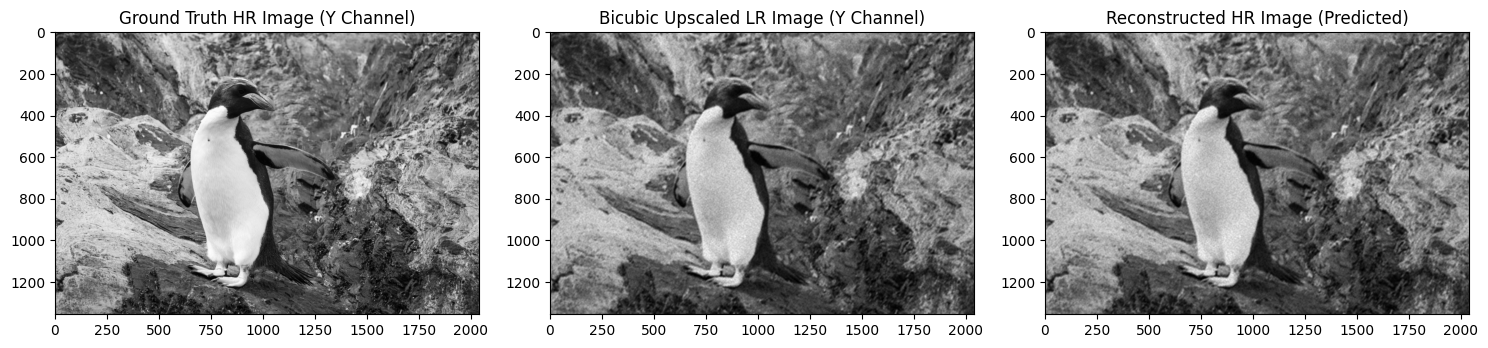


Evaluation Metrics:
MSE : 89.76212259239979
PSNR : 28.599872471333278


In [15]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.ndimage import zoom  # For interpolation

# Load the trained model
model_filename = "/content/drive/MyDrive/Assignment_ML/rf_sr_model.pkl"
rf = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

# Resize HR_YCbCr to (1356, 2040, 3) for MSE computation
HR_YCbCr_resized = Resize_YCbCr(HR_YCbCr, target_shape=(1356, 2040))

# Debugging dimensions
debug("Original HR_YCbCr dimensions", HR_YCbCr.shape)
debug("Resized HR_YCbCr dimensions", HR_YCbCr_resized.shape)

# Ensure HR_YCbCr_resized (Ground Truth HR) and LR_YCbCr (input LR) are available
if 'HR_YCbCr_resized' not in locals() or 'LR_YCbCr' not in locals():
    raise ValueError("HR_YCbCr_resized or LR_YCbCr is not defined. Ensure preprocessing is completed.")

# Use the same preprocessing applied to the Train_TestSet for prediction
predicted_residuals = rf.predict(Train_TestSet)  # Model's prediction of the residuals

# Check the length of predicted residuals
print(f"Predicted residuals length: {len(predicted_residuals)}")

# Bicubic interpolation to upscale LR image to match HR_YCbCr_resized dimensions
bicubic_LR = Upscale_Array(LR_YCbCr, HR_YCbCr_resized.shape[:2])  # Match HR_YCbCr_resized dimensions
bicubic_LR_channel = bicubic_LR[:, :, 0]  # Extract Y channel (luminance)

# Ensure predicted residuals are reshaped or interpolated to match dimensions
print(f"bicubic_LR_channel shape: {bicubic_LR_channel.shape}")
target_shape = bicubic_LR_channel.shape
print(f"Target shape for residuals: {target_shape}")

# If predicted residuals are 1D, reshape them
if predicted_residuals.ndim == 1:
    predicted_residuals = predicted_residuals.reshape(-1, 1)

# Calculate scaling factors to match target shape
scaling_factors = (
    target_shape[0] / predicted_residuals.shape[0],
    target_shape[1] / predicted_residuals.shape[1]
)
# print(f"Scaling factors: {scaling_factors}")

# Rescale predicted residuals using zoom
predicted_residuals_reshaped = zoom(predicted_residuals, scaling_factors, order=1)  # Linear interpolation

# Ensure reshaped residuals match target shape
if predicted_residuals_reshaped.shape != target_shape:
    raise ValueError("Reshaped residuals do not match target shape. Check scaling factors or input data.")

# Reconstruct HR image by adding predicted residuals to the bicubic LR image
reconstructed_HR = bicubic_LR_channel + predicted_residuals_reshaped

# Ground Truth HR image (Y channel) is HR_YCbCr_resized[:, :, 0]
gt_hr_y_channel = HR_YCbCr_resized[:, :, 0]

# Visualize the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(gt_hr_y_channel, cmap='gray')
plt.title("Ground Truth HR Image (Y Channel)")

plt.subplot(1, 3, 2)
plt.imshow(bicubic_LR_channel, cmap='gray')
plt.title("Bicubic Upscaled LR Image (Y Channel)")

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_HR, cmap='gray')
plt.title("Reconstructed HR Image (Predicted)")

plt.tight_layout()
plt.show()

# Compute MSE and PSNR for the Ground Truth comparison
mse_gt_vs_reconstructed = mean_squared_error(
    gt_hr_y_channel.flatten(),
    reconstructed_HR.flatten()
)
psnr_gt_vs_reconstructed = 20 * np.log10(255 / np.sqrt(mse_gt_vs_reconstructed))  # Assuming intensity in [0, 255]

# Compute MSE and PSNR for Bicubic vs Ground Truth as baseline
mse_gt_vs_bicubic = mean_squared_error(
    gt_hr_y_channel.flatten(),
    bicubic_LR_channel.flatten()
)
psnr_gt_vs_bicubic = 20 * np.log10(255 / np.sqrt(mse_gt_vs_bicubic))

# Print results
print(f"\nEvaluation Metrics:")
print(f"MSE : {mse_gt_vs_bicubic}")
print(f"PSNR : {psnr_gt_vs_bicubic}")


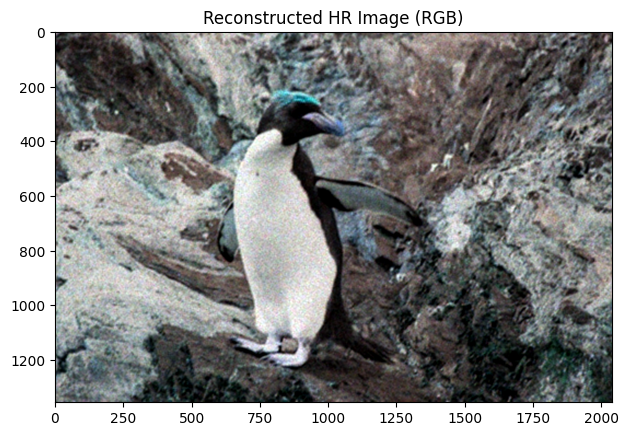

In [20]:
from skimage.color import ycbcr2rgb

# Ensure all images are in the correct format for conversion (Y, Cb, Cr combined)

# Combine channels for Reconstructed HR image
reconstructed_hr_ycbcr = np.stack([
    reconstructed_HR,           # Predicted Y channel
    bicubic_LR[:, :, 1],        # Cb channel from bicubic LR
    bicubic_LR[:, :, 2]         # Cr channel from bicubic LR
], axis=2)


# Convert YCbCr to RGB
reconstructed_hr_rgb = (ycbcr2rgb(reconstructed_hr_ycbcr) * 255).clip(0, 255).astype(np.uint8)
# plt.subplot(1, 3, 3)
plt.imshow(reconstructed_hr_rgb)
plt.title("Reconstructed HR Image (RGB)")

plt.tight_layout()
plt.show()


In [22]:
print(f"MSE (Ground Truth vs Reconstructed): {mse_gt_vs_reconstructed}")
print(f"PSNR (Ground Truth vs Reconstructed): {psnr_gt_vs_reconstructed}")

MSE (Ground Truth vs Reconstructed): 482.2972729824862
PSNR (Ground Truth vs Reconstructed): 21.297655545379964
